## Load needed things

### Import packages

In [6]:
import numpy as np
import nltk
import pandas as pd
import xml.etree.ElementTree as ET
from collections import namedtuple
from os import listdir
from os.path import isfile, join
import re
import string
from typing import Callable, List
import unidecode
from spellchecker import SpellChecker
import urllib.request
import json
from tqdm import tqdm
import spacy
import ftfy
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline
nlp = spacy.load('es')
tqdm.pandas()

### Define named tuple

In [2]:
tweet = namedtuple('Tweet', ['tweetid', 'content', 'polarity'])

### Define stopwords

In [3]:
stopWords = set(nltk.corpus.stopwords.words('spanish'))

## Preprocessing

### Read data

In [4]:
def read_data(file: str) -> pd.DataFrame:
    """Read data from given file and return it as a dataframe."""
    tweets: List = []
    with open(file, 'r') as f:
        tree = ET.parse(file)
        root = tree.getroot()
        for child in root:
            tweets.append(tweet(child[0].text, child[2].text, child[5][0][0].text))
    return pd.DataFrame(tweets)

def read_folder(folder: str) -> pd.DataFrame:
    """
    Read data from given folder, combines the training and dev set
    and return them combined as a dataframe.
    """
    dataframes = []
    files = [f for f in listdir(folder) if isfile(join(folder, f))]
    for file in files:
        if 'xml' in file:
            dataframes.append(read_data(folder + file))
    return pd.concat(dataframes)

### String manipulation

Don't need to care for emoticons, because there are less than 10.

In [5]:
def remove_mention(tweet: str) -> str:
    return re.sub(r'@[A-Za-z0-9]+', '', tweet) 

def lower_case(tweet: str) -> str:
    """Turn a tweet to lower case."""
    return tweet.lower()

def remove_question_mark(tweet: str) -> str:
    """Remove spanish question mark from a tweet."""
    return tweet.replace('¿', '')

def remove_punctuation(tweet: str) -> str:
    """Remove punctuation from a tweet."""
    return tweet.translate(str.maketrans('', '', string.punctuation))

def remove_whitespace(tweet: str) -> str:
    return tweet.strip()

def check_int(s):
    if s[0] in ('-', '+'):
        return s[1:].isdigit()
    return s.isdigit()

def remove_numbers(tweet: str) -> str:
    """Remove numbers from tweet."""
    tokenized = nltk.word_tokenize(tweet)
    return ' '.join([word for word in tokenized if not check_int(word)])

def fix_encoding(tweet: str) -> str:
    return ftfy.fix_encoding(tweet)

def fix_repeated_letters(tweet: str) -> str:
    """Replace repeated characters (3 repetitions or more) with only two characters."""
    return re.sub(r'(.)\1+', r'\1\1', tweet)

def clean_tweet(tweet: str) -> str:
    """Run a tweet through cleaning pipeline."""
    # List of function
    functions: List[Callable] = [
                 remove_mention,
                 lower_case,
                 remove_question_mark,
                 remove_punctuation,
                 remove_whitespace,
                 remove_numbers,
                 fix_encoding,
                 fix_repeated_letters
                 ]
    for f in functions:
        tweet = f(tweet)
        
    return tweet

### Spelling
Preprocessing that should be done after spell correction.

In [6]:
spell = SpellChecker(language='es')

def is_ascii(s):
    return all(ord(c) < 128 for c in s)

def fix_spelling(tweet: str) -> str:
    """Fix spelling error in tweets."""
    tokenized = nltk.word_tokenize(tweet)
    misspelled = spell.unknown(tokenized)
    for i in range(len(tokenized)):
        if tokenized[i] in misspelled:
            if is_ascii(tokenized[i]):
                contents = urllib.request.urlopen(f"http://api.urbandictionary.com/v0/define?term={tokenized[i]}").read()
                contents = json.loads(contents)['list']
            
                # Check if the word is spelling error or is in urban dictionary
                if contents and contents[0]['word'].lower().strip() == tokenized[i]:
                    continue
            tokenized[i] = spell.correction(tokenized[i])
    return ' '.join(tokenized)

def remove_stopwords(tweet: str) -> str:
    """Remove stopwords from tweet."""
    tokenized = nltk.word_tokenize(tweet)
    return ' '.join([word for word in tokenized if word not in stopWords])

def stem_tweet(tweet: str) -> str:
    tweet = nlp(tweet)
    return ' '.join([token.lemma_ for token in tweet])


def clean_tweet2(tweet: str) -> str:
    """Run a tweet through cleaning pipeline."""
    # List of function
    functions: List[Callable] = [
                 remove_stopwords,
                 stem_tweet
                 ]
    for f in functions:
        tweet = f(tweet)
        
    return tweet

### Clean and save

In [7]:
df = read_folder("data/cr/")
df['content'] = df['content'].progress_apply(clean_tweet)
df['content'] = df['content'].progress_apply(fix_spelling)
df['content'] = df['content'].progress_apply(clean_tweet2)
df.to_csv("data/cr/cleaned.csv")

100%|██████████| 1167/1167 [00:16<00:00, 71.88it/s]


## Explore data

### Load data from file

In [2]:
df = pd.read_csv("data/cr/cleaned.csv")

In [14]:
df.head()

,Unnamed: 0,tweetid,content,polarity
0,0,768225400254111744,totalmente puntual,NONE
1,1,770077064833671168,hola sandrita habia desear feliz dia madre tar...,P
2,2,771207534342320128,si andar hacer mejor quedar calladita jaja asi...,N
3,3,771900763987513345,pereza querer chocar banano,N
4,4,772550560998301697,bueno mayor cuánto campar tú sos cartaguito ca...,N


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 4 columns):
Unnamed: 0    1167 non-null int64
tweetid       1167 non-null int64
content       1167 non-null object
polarity      1167 non-null object
dtypes: int64(2), object(2)
memory usage: 36.5+ KB


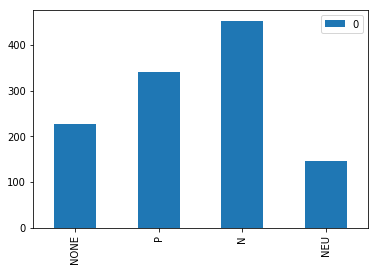

In [8]:
polarity_counts = Counter(df.polarity.values)
df = pd.DataFrame.from_dict(polarity_counts, orient='index')
df.plot(kind='bar')

## Classifier

### Turn tweets into features

In [9]:
all_words = nltk.FreqDist([word for tweet in df.content for word in nltk.word_tokenize(tweet)])
word_features = list(all_words)[:2000] # [_document-classify-all-words]

def document_features(document): # [_document-classify-extractor]
    document_words = set(nltk.word_tokenize(document)) # [_document-classify-set]
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

featuresets = [(document_features(d), c) for (d,c) in zip(df.content, df.polarity)]
train_set, test_set = featuresets[100:], featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.53


In [10]:
classifier.show_most_informative_features(5)

Most Informative Features
        contains(lindar) = True                P : N      =     13.9 : 1.0
        contains(triste) = True                N : P      =     12.6 : 1.0
         contains(final) = True              NEU : P      =     10.1 : 1.0
          contains(gran) = True                P : N      =      9.4 : 1.0
       contains(cambiar) = True              NEU : P      =      8.5 : 1.0
